In [83]:
'''from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
'''

"from google.colab import drive\n\n# Mount Google Drive\ndrive.mount('/content/drive')\n"

In [84]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, LearningRateScheduler

# Define image size and batch size
img_size = (224, 224)
batch_size = 4

os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [85]:
file_paths = os.listdir('Data2')
len(file_paths)

94

In [86]:
# Define paths to your data folders
data_dir = 'Data2'

In [87]:
lis = os.listdir(data_dir)
lis[:5]

['Chalcedony', 'Limestone', 'Lapis Lazuli', 'Sapphire Pink', 'Quartz Beer']

In [88]:
#Directly Deleting duplicate images function

import os
from PIL import Image
import hashlib

# Function to remove duplicate images based on hash comparison
def remove_duplicates(images_dir):
    # Create a dictionary to store hashes of images
    hash_dict = {}

    # Iterate through all images in the directory
    for root, dirs, files in os.walk(images_dir):
        for file in files:
            file_path = os.path.join(root, file)

            # Calculate the hash of the image file
            with open(file_path, 'rb') as f:
                file_hash = hashlib.md5(f.read()).hexdigest()

            # Check if the hash already exists in the dictionary
            if file_hash in hash_dict:
                # If hash exists, remove the duplicate image
                os.remove(file_path)
                print(f"Duplicate image removed: {file_path}")
            else:
                # If hash does not exist, add it to the dictionary
                hash_dict[file_hash] = file_path


# Function to remove corrupted images
def remove_corrupted_images(images_dir):
    # Iterate through all images in the directory
    for root, dirs, files in os.walk(images_dir):
        for file in files:
            file_path = os.path.join(root, file)

            try:
                # Attempt to open the image file
                with Image.open(file_path) as img:
                    img.verify()  # Verify if the image is valid
            except (IOError, SyntaxError) as e:
                # If image cannot be opened or is corrupted, remove it
                os.remove(file_path)
                print(f"Corrupted image removed: {file_path}")




In [89]:
# Example usage:
data_dir = 'Data2'

# Step 1: Data Cleaning

remove_corrupted_images(data_dir)

remove_duplicates(data_dir)

In [90]:
#Calucualting total images after cleaning

In [91]:
import os


def get_total_images(data_dir):
    total_images = 0
    for class_folder in os.listdir(data_dir):
        class_folder_path = os.path.join(data_dir, class_folder)
        if os.path.isdir(class_folder_path):
            total_images += len([file for file in os.listdir(class_folder_path) if file.endswith(('.jpg', '.jpeg', '.png'))])
    return total_images

In [92]:

data_dir = 'Data2'
total_images = get_total_images(data_dir)
print("Total images:", total_images)

Total images: 4764


In [93]:
num_classes= os.listdir('Data2')
data_dir = 'Data2'
total_images = get_total_images(data_dir)


In [94]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split



def preprocess_images(data_dir, total_images):
    # Get the list of class directories
    class_dirs = [class_name for class_name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, class_name))]
    num_classes = len(class_dirs)

    # Lists to store images and labels
    images = []
    labels = []

    # Loop through each class directory
    for class_dir in class_dirs:
        class_images_dir = os.path.join(data_dir, class_dir)
        # Loop through each image in the class directory
        for image_file in os.listdir(class_images_dir)[:total_images//num_classes]:
            image_path = os.path.join(class_images_dir, image_file)
            # Read the image
            image = cv2.imread(image_path)
            # Resize the image to a fixed size (e.g., 224x224)
            image = cv2.resize(image, (224, 224))
            # Normalize pixel values to be between 0 and 1
            # image = image.astype(np.float32) / 255.0
            # Append the image and its label to the lists
            images.append(image)
            labels.append(class_dir)  # Using class directory name as label

    # Convert lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Split the data into training and testing sets
    train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

    return train_images, test_images, train_labels, test_labels

In [95]:
train_images, test_images, train_labels, test_labels = preprocess_images(data_dir, total_images)
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Train images shape: (2547, 224, 224, 3)
Train labels shape: (2547,)
Test images shape: (637, 224, 224, 3)
Test labels shape: (637,)


In [96]:

def preprocess_images_and_labels(data_dir, total_images):
    images = []
    labels = []

    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        for image_file in os.listdir(class_dir)[:total_images//len(os.listdir(data_dir))]:
            image_path = os.path.join(class_dir, image_file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (224, 224))
            image = image.astype(np.float32) / 255.0
            images.append(image)
            labels.append(class_name)

    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels


In [97]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
import os
import cv2
import numpy as np

def preprocess_images_and_labels(data_dir, total_images):
    images = []
    labels = []

    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        for image_file in os.listdir(class_dir)[:total_images//len(os.listdir(data_dir))]:
            image_path = os.path.join(class_dir, image_file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (224, 224))
            image = image.astype(np.float32) / 255.0
            images.append(image)
            labels.append(class_name)

    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels


In [105]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Normalization, Dropout, Attention
from keras.applications import VGG16, ResNet50, ResNet50V2
from keras.regularizers import l2, l1
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
import os
import cv2
import numpy as np


# Load the VGG16 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Add custom layers on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    ###add a couple of more layers
    #Attention(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    #Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    #Dropout(0.5),
    #Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    #Dropout(0.5),
    Dense(94, activation='softmax')
])

# Compile the model
model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_13 (Dense)            (None, 512)               51380736  
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 94)               

In [99]:

from sklearn.utils import shuffle

train_images, train_labels = preprocess_images_and_labels(data_dir, total_images)



# Shuffle the images and labels
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)

# Create ImageDataGenerator for data augmentation and flow from directory
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow(train_images, train_labels, batch_size=batch_size, subset='training', seed=42)
validation_generator = datagen.flow(train_images, train_labels, batch_size=batch_size, subset='validation', seed=42)



libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [100]:

# Early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
epochs = 20  # Adjust the number of epochs
def step_decay(epoch):
    initial_lr = 0.001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 5  # Number of epochs after which learning rate will drop
    new_lr = initial_lr * (drop ** (epoch // epochs_drop))
    return new_lr


def ramp_up_learning_rate(epoch, initial_lr=1e-4, rampup_length=10):
    start_lr = initial_lr; min_lr = 1e-3; max_lr = 2e-3

    # define the number of epochs to increase 
    # LR lineary and then the decay factor
    rampup_epochs = 5; sustain_epochs = 0; exp_decay = .5

    # method to update the LR value based on the current epoch
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs,
           sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) / rampup_epochs
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) *
                      exp_decay**(epoch - rampup_epochs -
                                    sustain_epochs) + min_lr)
        return lr

    return lr(epoch, start_lr, min_lr, max_lr,
              rampup_epochs, sustain_epochs, exp_decay)
    
rampupLR = LearningRateScheduler(lambda epochs: ramp_up_learning_rate(epochs, rampup_length=5, initial_lr=0.01), verbose=1)
learnRateSch = LearningRateScheduler(step_decay)

In [101]:
'''# Calculate the number of steps per epoch and validation steps
steps_per_epoch = len(train_images) // batch_size
validation_steps = len(validation_generator)

# Train the model
epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,

    callbacks=[early_stopping]
)'''

'# Calculate the number of steps per epoch and validation steps\nsteps_per_epoch = len(train_images) // batch_size\nvalidation_steps = len(validation_generator)\n\n# Train the model\nepochs = 5\nhistory = model.fit(\n    train_generator,\n    steps_per_epoch=steps_per_epoch,\n    epochs=epochs,\n    validation_data=validation_generator,\n    validation_steps=validation_steps,\n\n    callbacks=[early_stopping]\n)'

In [102]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True)

test_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False)  # No need to shuffle the validation data


data_dir = 'Data2'

# Create ImageDataGenerator with automatic split and classes=None
# datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# train_generator = datagen.flow_from_directory(
#         data_dir,
#         target_size=img_size,
#         batch_size=batch_size,
#         class_mode='sparse',  # Use 'sparse' for multi-class classification
#         subset='training',
#         shuffle=True)

# test_generator = datagen.flow_from_directory(
#         data_dir,
#         target_size=img_size,
#         batch_size=batch_size,
#         class_mode='sparse',  # Use 'sparse' for multi-class classification
#         subset='validation',
#         shuffle=False)


Found 3859 images belonging to 94 classes.
Found 924 images belonging to 94 classes.


In [103]:
# Compile the model with 'sparse_categorical_crossentropy' as the loss function
'''model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])'''

"model.compile(optimizer='adam',\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])"

In [107]:
### now we will compile the model
from keras.models import load_model

name = 'testModel2.h5'

try:
    model = load_model(name)
    print("Model loaded successfully")
except:
    print("No model found")

model_save = ModelCheckpoint(name, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      epochs=40,
      validation_data=test_generator,
      validation_steps=test_generator.samples // batch_size,
      callbacks=[rampupLR, model_save])

No model found

Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/40
964/964 [==============================] - 97s 89ms/step - loss: 5.8664 - accuracy: 0.0729 - val_loss: 5.2178 - val_accuracy: 0.0660 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.0084.
Epoch 2/40
964/964 [==============================] - 89s 92ms/step - loss: 5.1264 - accuracy: 0.0859 - val_loss: 4.7633 - val_accuracy: 0.1212 - lr: 0.0084

Epoch 3: LearningRateScheduler setting learning rate to 0.0068000000000000005.
Epoch 3/40
834/964 [========================>.....] - ETA: 10s - loss: 4.8478 - accuracy: 0.1031

KeyboardInterrupt: 

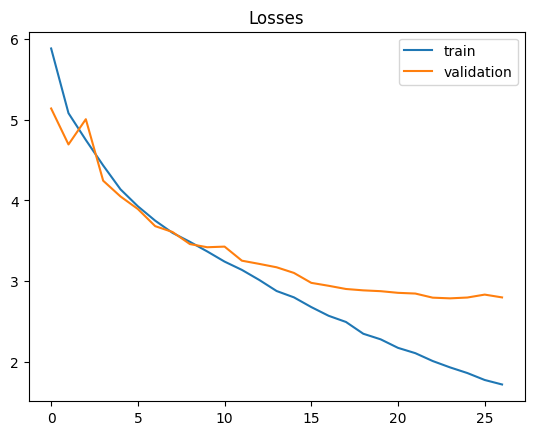

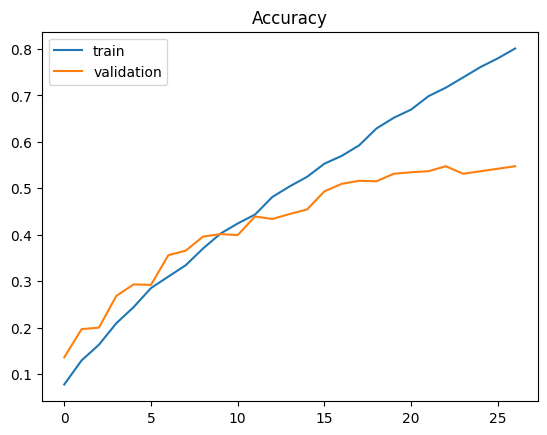

In [72]:
### Now we will plot the loss and accuracy of the model
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.title('Losses')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'])
plt.title('Accuracy')
plt.show()

In [73]:

# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Accuracy:", accuracy)

231/231 [==============================] - 4s 18ms/step - loss: 2.7848 - accuracy: 0.5314
Test Accuracy: 0.5313853025436401


In [74]:
from keras.preprocessing import image
import numpy as np

# Load a sample image
sample_img_path = '1.jpg'  # Path to your sample image
img = image.load_img(sample_img_path, target_size=img_size)


In [75]:
# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
#img_array /= 255.0  # Rescale pixel values


In [76]:

# Use the trained model to make predictions
predictions = model.predict(img_array)


1/1 [==============================] - 1s 626ms/step


In [77]:
# Decode the predictions
predicted_class = np.argmax(predictions[0])
class_labels = train_generator.class_indices
predicted_label = [k for k, v in class_labels.items() if v == predicted_class][0]

# Print the predicted class label
print("Predicted Class:", predicted_label)

Predicted Class: Marble


In [78]:
# prompt: generate a confusion matrix

import numpy as np
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
confusion_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print(confusion_matrix)


231/231 [==============================] - 4s 16ms/step
[[1 0 0 ... 0 1 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 1]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 0]]


<Axes: >

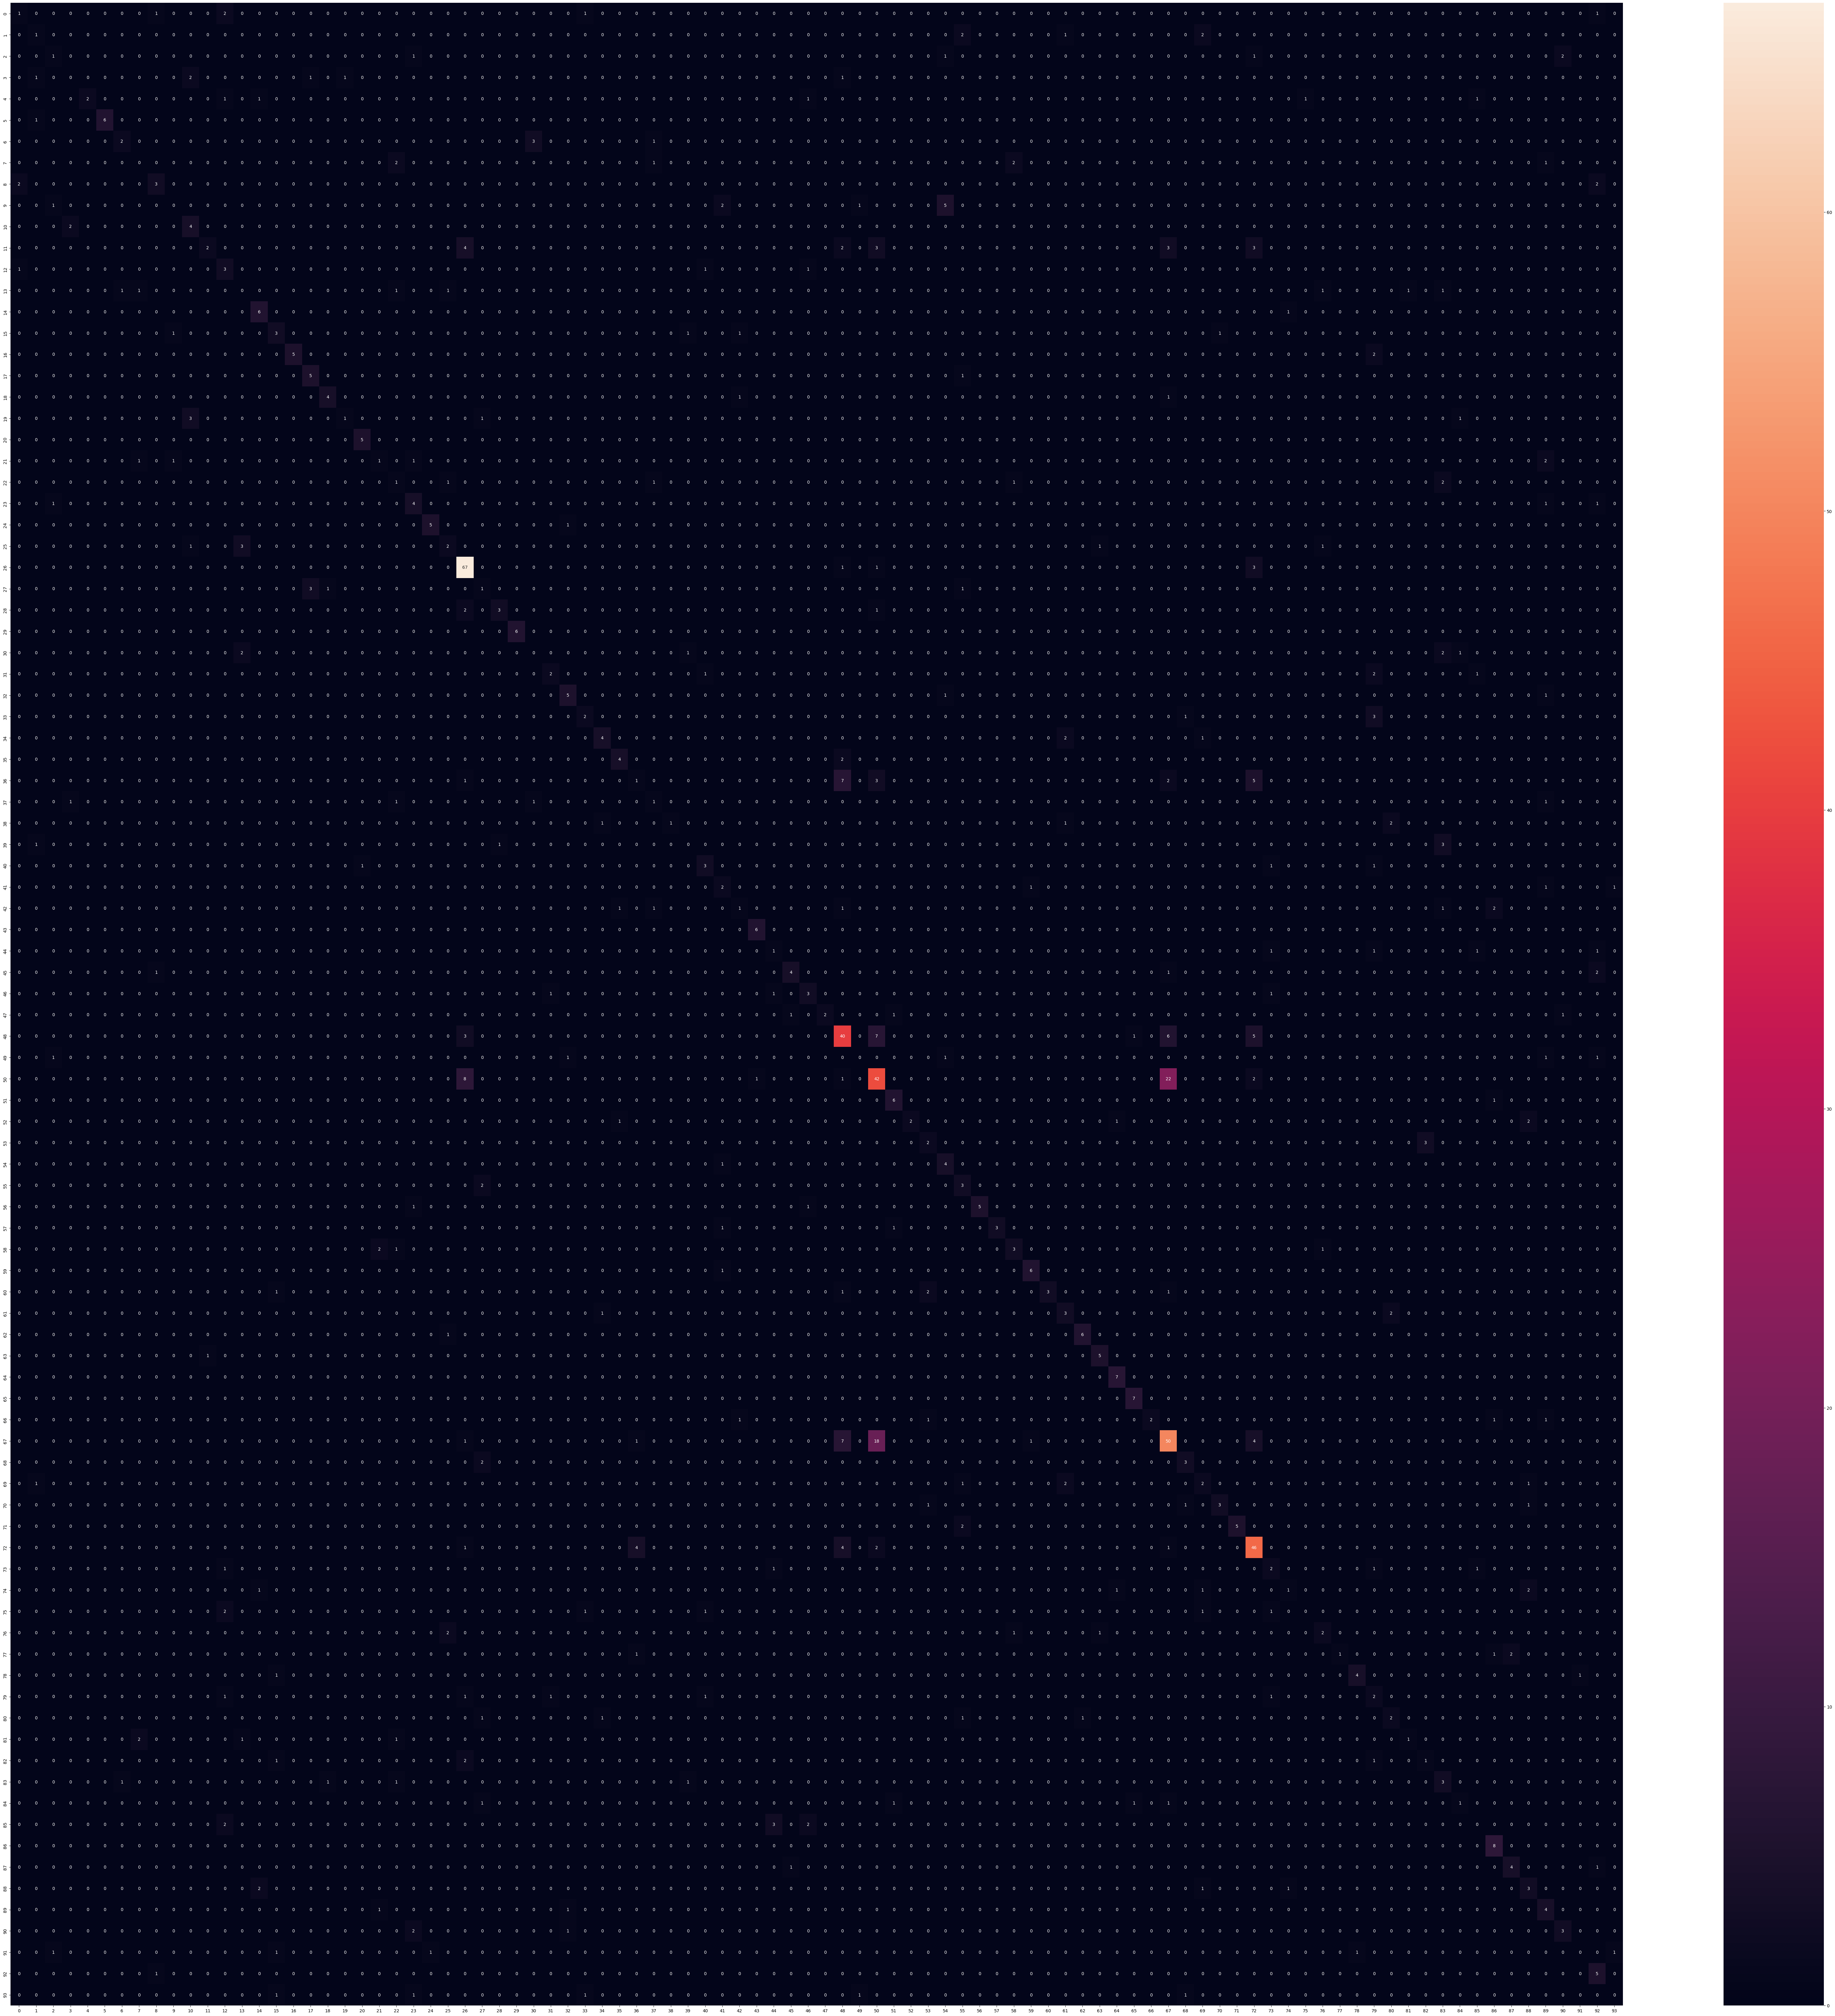

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(84, 84))
sns.heatmap(confusion_matrix, annot=True, fmt="d")


In [32]:
# prompt: Print F1 score

from sklearn.metrics import f1_score

# Calculate F1 score
f1_score = f1_score(y_true, y_pred, average='weighted')

# Print the F1 score
print("F1 Score:", f1_score)


F1 Score: 0.6337516383000241


In [80]:
#### now we will load the model and test it on a new image
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('testModel.h5')

# Load a sample image
sample_img_path = '1.jpg'  # Path to your sample image
img = image.load_img(sample_img_path, target_size=img_size)

# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Rescale pixel values

# Use the trained model to make predictions
predictions = model.predict(img_array)

# Decode the predictions
predicted_class = np.argmax(predictions[0])
class_labels = train_generator.class_indices
predicted_label = [k for k, v in class_labels.items() if v == predicted_class][0]
print("Predicted Class:", predicted_label)

1/1 [==============================] - 1s 561ms/step
Predicted Class: Sandstone


In [82]:
class_labels = train_generator.class_indices
print("Class Labels:", class_labels)

### Save the indices to json file
import json
data = json.dumps(class_labels)
with open('class_labels.json', 'w') as f:
    f.write(data)


Class Labels: {'Alexandrite': 0, 'Almandine': 1, 'Amazonite': 2, 'Amber': 3, 'Amethyst': 4, 'Ametrine': 5, 'Andalusite': 6, 'Andradite': 7, 'Aquamarine': 8, 'Aventurine Green': 9, 'Aventurine Yellow': 10, 'Basalt': 11, 'Benitoite': 12, 'Beryl Golden': 13, 'Bixbite': 14, 'Bloodstone': 15, 'Blue Lace Agate': 16, 'Carnelian': 17, 'Cats Eye': 18, 'Chalcedony': 19, 'Chalcedony Blue': 20, 'Chrome Diopside': 21, 'Chrysoberyl': 22, 'Chrysocolla': 23, 'Chrysoprase': 24, 'Citrine': 25, 'Coal': 26, 'Coral': 27, 'Danburite': 28, 'Diamond': 29, 'Diaspore': 30, 'Dumortierite': 31, 'Emerald': 32, 'Fluorite': 33, 'Garnet Red': 34, 'Goshenite': 35, 'Granite': 36, 'Grossular': 37, 'Hessonite': 38, 'Hiddenite': 39, 'Iolite': 40, 'Jade': 41, 'Jasper': 42, 'Kunzite': 43, 'Kyanite': 44, 'Labradorite': 45, 'Lapis Lazuli': 46, 'Larimar': 47, 'Limestone': 48, 'Malachite': 49, 'Marble': 50, 'Moonstone': 51, 'Morganite': 52, 'Onyx Black': 53, 'Onyx Green': 54, 'Onyx Red': 55, 'Opal': 56, 'Pearl': 57, 'Peridot': 

In [37]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(512, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(94, activation='softmax')
])

model2.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      epochs=40,
      validation_data=test_generator,
      validation_steps=test_generator.samples // batch_size,
      callbacks=[early_stopping, rampupLR])



2024-03-26 23:08:59.469374: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-26 23:08:59.469423: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-26 23:08:59.469441: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-26 23:08:59.527941: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/40


2024-03-26 23:09:03.154133: W tensorflow/core/kernels/gpu_utils.cc:54] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2024-03-26 23:09:15.315201: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.50GiB (rounded to 1614938112)requested by op gradient_tape/sequential_1/max_pooling2d/MaxPool/MaxPoolGrad
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-03-26 23:09:15.315255: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-03-26 23:09:15.315272: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 139, Chunks in use: 139. 34.8KiB allocated for chunk

# We have tried a basic CNN model for our Image data which ended up having an accuracy of 25 percent which is low. Now I am considering the implementation of Vision Transformers (ViT) to extract features from the images. By leveraging ViT, we can capture more nuanced and abstract features from the dataset, potentially leading to better representation and classification performance.



In [ ]:
#### here we will use Vit model as a transfer learning model and pass it to a couple of layers to make it a custom model 
from vit_keras import  vit, utils

base_model = vit.vit_b16(image_size=img_size[0], activation='softmax', pretrained=True)

/home/tarush/.local/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [ ]:
def generator(features, labels, batch_size):
    # Create empty arrays to contain batch of features and labels
    batch_features = np.zeros((batch_size, *features.shape[1:]))
    batch_labels = np.zeros((batch_size,))

    while True:
        for i in range(batch_size):
            # Choose random index in features
            index = np.random.choice(len(features),1)[0]
            batch_features[i] = features[index]
            batch_labels[i] = labels[index]
        yield batch_features, batch_labels

In [ ]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(94, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 1000)              86567656  
                                                                 
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               512512    
                                                                 
 dense_3 (Dense)             (None, 94)                48222     
                                                                 
Total params: 87128390 (332.37 MB)
Trainable params: 87128390 (332.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
epochs = 20  # Adjust the number of epochs
def step_decay(epoch):
    initial_lr = 0.001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 5  # Number of epochs after which learning rate will drop
    new_lr = initial_lr * (drop ** (epoch // epochs_drop))
    return new_lr

learnRateSch = LearningRateScheduler(step_decay)
train_generator = generator(train_images, train_labels, batch_size)
test_generator = generator(test_images, test_labels, batch_size)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_images) // batch_size,
    callbacks=[early_stopping, learnRateSch]
)

Epoch 1/20
398/398 [==============================] - ETA: 0s - loss: 4.5364 - accuracy: 0.0141

ValueError: could not convert string to float: 'Dumortierite'

In [ ]:
### Now we will plot the loss and accuracy of the model
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.title('Losses')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'])
plt.title('Accuracy')
plt.show()

loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Accuracy:", accuracy)